In [330]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Tartyb:
1- salt and pepper
2- brightness
3- rotation


Crop barcode

In [331]:
def show_image(title, image):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def crop_barcode(image, output_path):
    # Read the image
 
    # Convert the image to grayscale
    gray = image

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Apply edge detection
    edged = cv2.Canny(blurred, 50, 200, 255)

    # Apply morphological operations to close gaps in the edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    # Show the edged image
    show_image("Edged Image", edged)
    show_image("Closed Image", closed)

    # Find contours in the closed image
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area, keeping only the largest one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    barcode_contour = None

    # Loop over the contours to find the one that likely represents the barcode
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # If the approximated contour has four points, we can assume we have found the barcode
        if len(approx) == 4:
            barcode_contour = approx
            break

    if barcode_contour is not None:
        # Get the points of the contour (in order of top-left, top-right, bottom-right, bottom-left)
        points = barcode_contour.reshape(4, 2)

        # Order the points in a consistent way
        points = sorted(points, key=lambda x: x[0])
        (tl, tr) = sorted(points[:2], key=lambda x: x[1])  # top-left, top-right
        (bl, br) = sorted(points[2:], key=lambda x: x[1])  # bottom-left, bottom-right

        # The ordered points for the perspective transform
        ordered_points = np.array([tl, tr, br, bl], dtype="float32")

        # Define the width and height of the new image (horizontal rectangle)
        width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
        height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))

        # Define the destination points for the perspective transform (a rectangular region)
        destination_points = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype="float32")

        # Compute the perspective transform matrix
        matrix = cv2.getPerspectiveTransform(ordered_points, destination_points)

        # Apply the perspective transform to straighten the barcode region
        straightened_image = cv2.warpPerspective(image, matrix, (width, height))

        # Check if the image is taller than it is wide
        if straightened_image.shape[0] > straightened_image.shape[1]:
            # Rotate the image to make it horizontal (counterclockwise rotation)
            straightened_image = cv2.rotate(straightened_image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Show the straightened barcode
        show_image("Straightened Barcode", straightened_image)

        # Save the straightened image
        cv2.imwrite(output_path, straightened_image)
        print(f"Straightened image saved to {output_path}")
        return True
    else:
        print("No barcode detected")
        return False

In [332]:
def crop_largest_rectangle(image, output_path):
    # Load the image

    inverted = cv2.bitwise_not(image)

    # Threshold the image (binarize)

    _, thresh = cv2.threshold(inverted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological closing to fill small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find external contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("No contours found.")
        return

    # Find the largest contour based on area
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate the contour to handle irregularities
    hull = cv2.convexHull(largest_contour)  # Convex hull ensures we cover missing corners

    # Get the minimum area bounding rectangle around the hull
    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int32(box)  # Convert to integer points

    # Draw the detected rectangle on the original image (for visualization)
    image_copy = image.copy()
    cv2.drawContours(image_copy, [box], -1, (0, 255, 0), 2)
    show_image("Detected Rectangle", image_copy)

    # Perspective transformation
    width = int(rect[1][0])
    height = int(rect[1][1])
    src_pts = box.astype("float32")
    dst_pts = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")

    # Compute the perspective transform matrix
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(image, matrix, (width, height))

    # Remove the unnecessary rotation
    # Instead, adjust the output dimensions to maintain aspect ratio
    output_width = max(width, height)
    output_height = min(width, height)

    # Resize the warped image to fit the desired output size
    resized_warped = cv2.resize(warped, (output_width, output_height))

    # Show and save the result
    show_image("Cropped Rectangle", resized_warped)
    cv2.imwrite(output_path, resized_warped)
    print(f"Cropped rectangle saved to {output_path}")

Detect Noises Functions


In [333]:
detected_noises = []  # Detected noise types


Salt and Pepper

In [334]:
threshold_sp = 20  
def fix_saltPepper(processed_image):
    processed_image = cv2.medianBlur(cv2.blur(processed_image, (1, 7)), 3)  # Apply a median filter first
    _, processed_image = cv2.threshold(processed_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply Otsu's thresholding
    return processed_image   # Salt-and-pepper noise threshold
def detect_saltPepper_noise(image):

    # Check for salt-and-pepper noise
    median_diff = np.mean(np.abs(image - cv2.medianBlur(image, 3)))
    if median_diff > threshold_sp:
        detected_noises.append('salt_pepper')
        image=fix_saltPepper(image)
    cv2.imwrite("salt_pepper.jpg", image)
    return image    

sine wave 

In [335]:
def detect_noise_sine_waves(image, z_score_threshold=2.5, low_freq_cutoff_ratio=0.02, high_freq_cutoff_ratio=0.5):
        """
        Detect noise sine waves in an image while avoiding structured patterns (e.g., barcodes).

        Parameters:
            image (numpy.ndarray): Input image (grayscale).
            z_score_threshold (float): Z-score threshold for detecting noise.
            low_freq_cutoff_ratio (float): Low frequency cutoff as a ratio of image size.
            high_freq_cutoff_ratio (float): High frequency cutoff as a ratio of image size.

        Returns:
            numpy.ndarray: Binary mask highlighting detected sine wave noise.
        """
        # Convert the image to grayscale if it is not
        gray_image = image

        # Step 1: Apply FFT to transform the image to the frequency domain
        dft = np.fft.fft2(gray_image)
        dft_shift = np.fft.fftshift(dft)
        magnitude_spectrum = np.abs(dft_shift)

        # Step 2: Compute z-scores of the magnitude spectrum
        mean_mag = np.mean(magnitude_spectrum)
        std_mag = np.std(magnitude_spectrum)
        z_scores = (magnitude_spectrum - mean_mag) / std_mag

        # Step 3: Create a frequency filter
        rows, cols = gray_image.shape
        center_row, center_col = rows // 2, cols // 2
        low_freq_cutoff = int(min(rows, cols) * low_freq_cutoff_ratio)
        high_freq_cutoff = int(min(rows, cols) * high_freq_cutoff_ratio)

        # Create a circular band-pass filter
        y, x = np.ogrid[:rows, :cols]
        distance_from_center = np.sqrt((x - center_col)**2 + (y - center_row)**2)
        band_pass_filter = (distance_from_center >= low_freq_cutoff) & (distance_from_center <= high_freq_cutoff)

        # Exclude central frequencies (structured patterns like barcodes)
        exclusion_width = int(min(rows, cols) * 0.05)  # Exclude a small width around central axes
        band_pass_filter[center_row - exclusion_width:center_row + exclusion_width, :] = False
        band_pass_filter[:, center_col - exclusion_width:center_col + exclusion_width] = False

        # Apply the band-pass filter to the z-score mask
        sine_wave_mask = (z_scores > z_score_threshold) & band_pass_filter

        # Step 4: Enhance the detected regions using dilation
        kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size to control dilation
        enhanced_mask = cv2.dilate(sine_wave_mask.astype(np.uint8), kernel, iterations=1)

        # Step 5: Create an output image highlighting the sine wave noise
        sine_wave_image = np.zeros_like(gray_image)
        sine_wave_image[enhanced_mask > 0] = 255  # Highlight detected noise patterns

        # DEBUG: Display the magnitude spectrum, filter, and detection
        plt.figure(figsize=(15, 8))

        plt.subplot(1, 3, 1)
        plt.title("Magnitude Spectrum (Log Scale)")
        plt.imshow(np.log(1 + magnitude_spectrum), cmap='gray')
        plt.colorbar()
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Band-Pass Filter")
        plt.imshow(band_pass_filter, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Enhanced Sine Wave Noise")
        plt.imshow(sine_wave_image, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Check if any sine waves were detected
        if np.any(enhanced_mask):
            print("Noise sine waves detected.")
            detected_noises.append('sine_wave')
        else:
            print("No noise sine waves detected.")

        return sine_wave_image

    # Example usage:
    # Load an image (grayscale or color)


    # image_path = 'C://Uni//Senior 1 Sem1//CV//Project//barcode_vision//Test Case Images//11 - bayza 5ales di bsara7a.jpg'
    # #image_path = 'C://Uni//Senior 1 Sem1//CV//Project//barcode_vision//Test Case Images//07 - mal7 w felfel.jpg'
    # input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # # Detect noise sine waves
    # sine_wave_image = detect_noise_sine_waves(input_image, z_score_threshold=2.5, low_freq_cutoff_ratio=0.02, high_freq_cutoff_ratio=0.5)

    # # Save the result
    # cv2.imwrite('sine_wave_image.jpg', sine_wave_image)

    # # Display the result using Matplotlib
    # plt.figure(figsize=(10, 5))

    # plt.subplot(1, 2, 1)
    # plt.title('Original Image')
    # plt.imshow(input_image, cmap='gray')
    # plt.axis('off')

    # plt.subplot(1, 2, 2)
    # plt.title('Enhanced Sine Wave Noise Detection')
    # plt.imshow(sine_wave_image, cmap='gray')
    # plt.axis('off')

    # plt.show()


Blurred

In [336]:
def detect_image_is_blurred(image):
    # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:  # Check if the image is colored (3 channels)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Apply Laplacian to the image
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)

    # Calculate the variance of the Laplacian
    laplacian_var = np.var(laplacian)

    # Set a threshold value based on the image type
    blur_threshold = 10000000  # You can adjust this threshold as needed

    # Check if the variance is below the threshold (indicating blur)
    if laplacian_var < blur_threshold:
        detected_noises.append('blurred')
        print("Blur detected")
    else:
        print("Image is not blurred")

Brightness

In [337]:
def adjustBrightness(image, target_brightness=128, threshold=80):
    gray = image
    avg_brightness = np.mean(gray)
    beta = target_brightness - avg_brightness
    new_image = cv2.convertScaleAbs(image, alpha=1.0, beta=beta)
   # _, new_image = cv2.threshold(new_image, 20, 255, cv2.THRESH_BINARY)
    return new_image
def detect_brightness(image, target_brightness=128, threshold=60):
    gray = image
    avg_brightness = np.mean(gray)
    print(f"Average brightness: {avg_brightness}")
    if abs(target_brightness - avg_brightness) > threshold:
        print("Brightness adjustment needed.")
        image = adjustBrightness(image, target_brightness, threshold)
        _, gray_binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        show_image("Binarized Grayscale Image", gray_binary)
        detected_noises.append('brightness')
        cv2.imwrite("brightness.jpg", gray_binary)
        return gray_binary
    else:
        print("Brightness is within acceptable range.")
    return image

Contrast

In [338]:
def detect_low_contrast(image, threshold=22):

    min_pixel = np.min(image)
    max_pixel = np.max(image)
    contrast_range = max_pixel - min_pixel

    print(f"Min Intensity: {min_pixel}, Max Intensity: {max_pixel}, Contrast Range: {contrast_range}")
    #show image using matplotlib
   # plt.imshow(image, cmap='gray')
    is_low_contrast = contrast_range < threshold
    if is_low_contrast:
        print("Low contrast detected")
        detected_noises.append('low_contrast')
        _, binary_image = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        cv2.imwrite("low_contrast.jpg",binary_image)
        return binary_image   

  
    else:
        print("Contrast is within acceptable range. No adjustments needed.")
        #plt.imshow(image, cmap='gray')
        return image
     

Rotation


In [339]:
def detect_rotation(image):
    # Read the image


    # Convert the image to grayscale
    gray = image

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Apply edge detection
    edged = cv2.Canny(blurred, 50, 200, 255)

    # Apply morphological operations to close gaps in the edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)


    # Find contours in the closed image
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area, keeping only the largest one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    barcode_contour = None

    # Loop over the contours to find the one that likely represents the barcode
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # If the approximated contour has four points, we can assume we have found the barcode
        if len(approx) == 4:
            barcode_contour = approx
            break

    if barcode_contour is not None:
        print("Barcode detected")

    else:
        print("No barcode detected")
        detected_noises.append('Rotation')

In [340]:
def detect_noises(image_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    image2 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, image2 = cv2.threshold(image2, 20, 255, cv2.THRESH_BINARY)
    image = detect_saltPepper_noise(image)
    image = detect_low_contrast(image)
    image = detect_brightness(image)

    
    #show_image rn using matplotlib
    plt.imshow(image, cmap='gray')
    found = crop_barcode(image, 'output.jpg')
    if not found:
        crop_largest_rectangle(image2, 'output.jpg')
    if found:     
        detect_noise_sine_waves(image)
        detect_image_is_blurred(image)


Test Detect

In [341]:
detected_noises = []

Min Intensity: 0, Max Intensity: 255, Contrast Range: 255
Contrast is within acceptable range. No adjustments needed.
Average brightness: 226.01009166666665
Brightness adjustment needed.


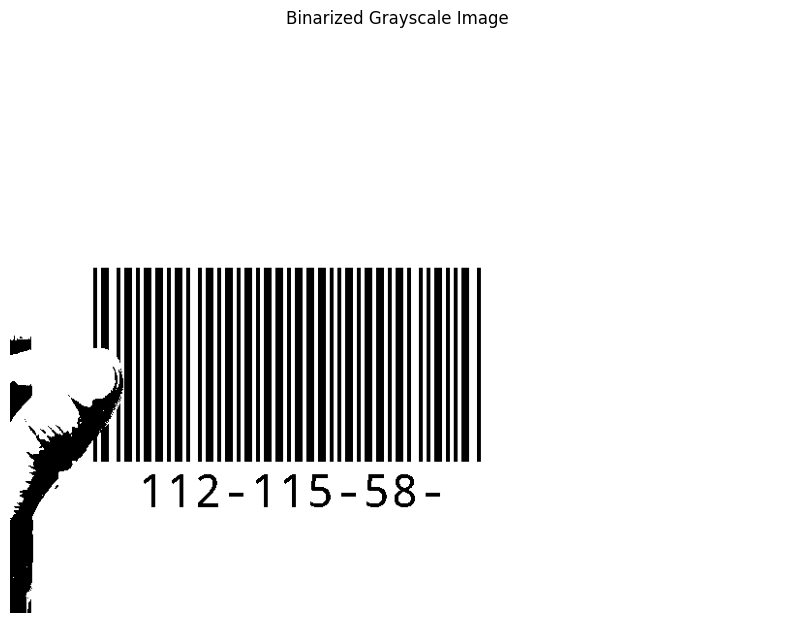

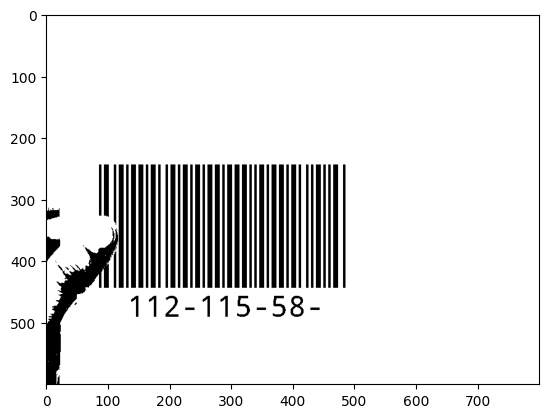

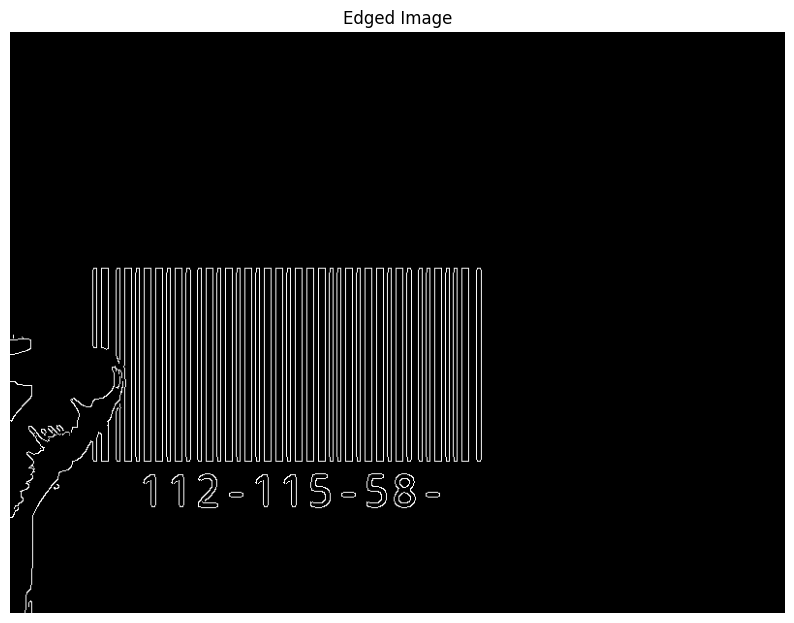

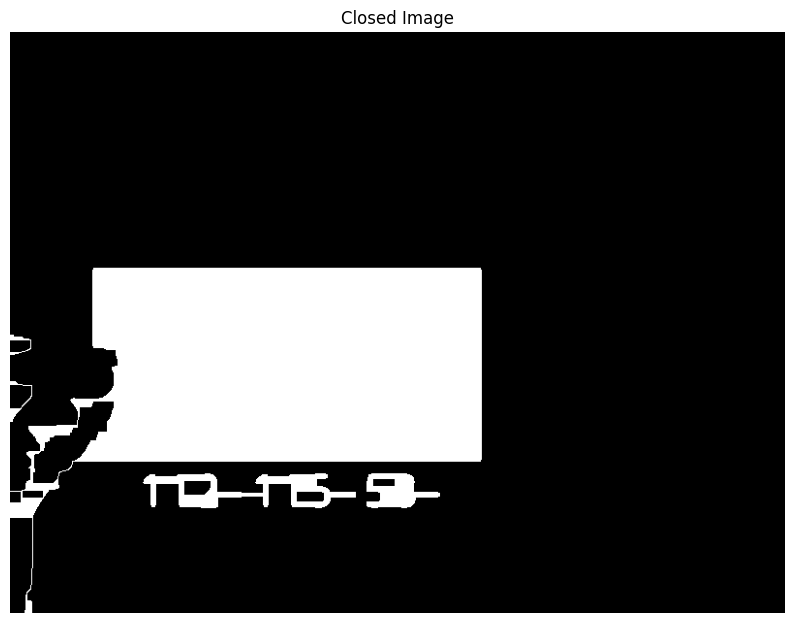

No barcode detected


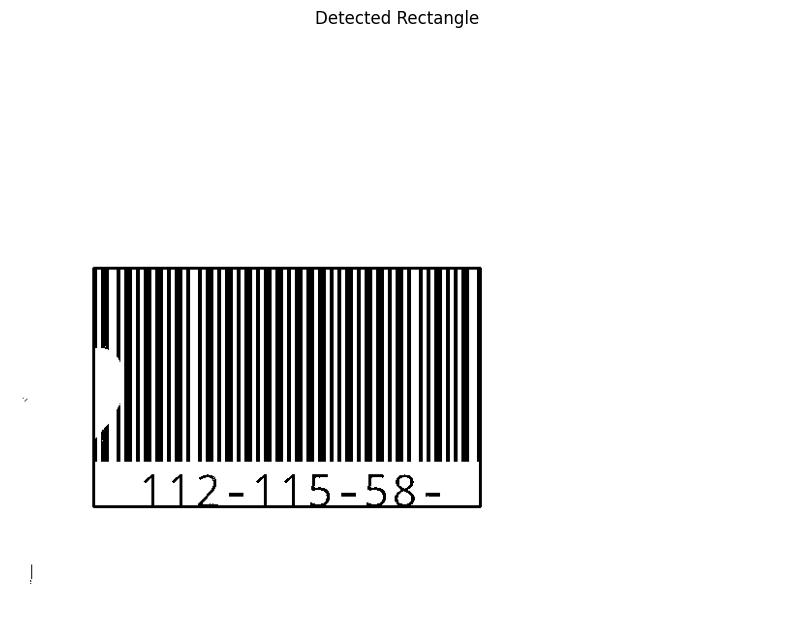

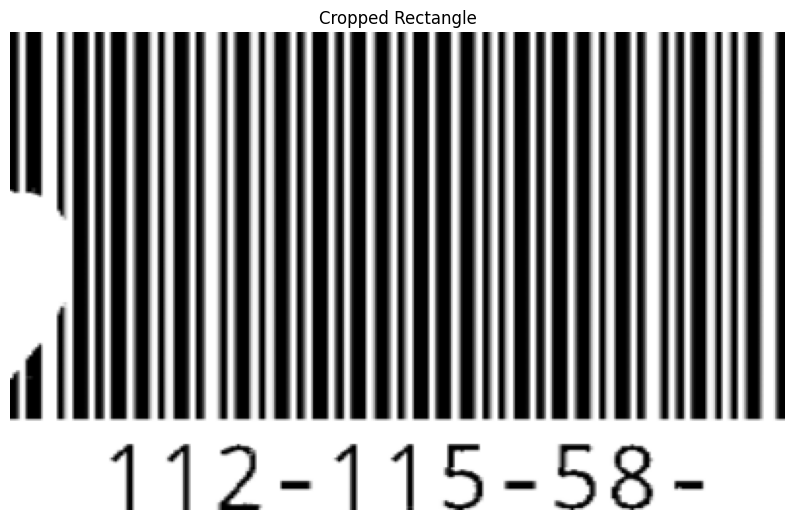

Cropped rectangle saved to output.jpg


In [342]:
detect_noises("C://Uni//Senior 1 Sem1//CV//Project//barcode_vision//Test Case Images//03 - eda ya3am ew3a soba3ak mathazarsh.jpg")

In [343]:
detected_noises

['brightness']

Preprocess (fixing)

Salt and Pepper

In [344]:
def fix_saltPepper(image):
    processed_image = cv2.medianBlur(cv2.blur(processed_image, (1, 7)), 3)  # Apply a median filter first
    _, processed_image = cv2.threshold(processed_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply Otsu's thresholding
    return processed_image

Adjust Brightness

In [345]:
def adjustBrightness(image, target_brightness=128, threshold=30):
    gray = image
    avg_brightness = np.mean(gray)
    beta = target_brightness - avg_brightness
    if abs(beta) > threshold:
        new_image = cv2.convertScaleAbs(image, alpha=1.0, beta=beta)
    else:
        new_image = image
    return new_image

In [346]:
def preprocess_image(image_path, noise_types):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    processed_image = image.copy()
    detected_noises = []
    detect_noises(processed_image)


    if 'salt_pepper' in detected_noises:

        processed_image = fix_saltPepper(processed_image)
        detected_noises = []
        detect_noises(processed_image)

    if 'brightness' in detected_noises:
        processed_image = adjustBrightness(processed_image)
        detected_noises = []
        detect_noises(processed_image)



    return processed_image

In [347]:
# Read barcode image
image = cv2.imread('Test Case Images/07 - mal7 w felfel.jpg', cv2.IMREAD_GRAYSCALE)

In [348]:
detect_noises(image, detected_noises)
print(f"Detected noise types: {detected_noises}")

TypeError: detect_noises() takes 1 positional argument but 2 were given

In [13]:
# Apply preprocessing
processed_image = preprocess_image(image, detected_noises)

In [14]:
#Save or display the result
cv2.imwrite('processed_barcode.jpg', processed_image)

True

In [164]:
def show_image(title, image):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def crop_barcode(image_path, output_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image from {image_path}")
        return

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Apply edge detection
    edged = cv2.Canny(blurred, 50, 200, 255)

    # Apply morphological operations to close gaps in the edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    # Show the edged image
    show_image("Edged Image", edged)
    show_image("Closed Image", closed)

    # Find contours in the closed image
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area, keeping only the largest one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    barcode_contour = None

    # Loop over the contours to find the one that likely represents the barcode
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # If the approximated contour has four points, we can assume we have found the barcode
        if len(approx) == 4:
            barcode_contour = approx
            break

    if barcode_contour is not None:
        # Get the points of the contour (in order of top-left, top-right, bottom-right, bottom-left)
        points = barcode_contour.reshape(4, 2)

        # Order the points in a consistent way
        points = sorted(points, key=lambda x: x[0])
        (tl, tr) = sorted(points[:2], key=lambda x: x[1])  # top-left, top-right
        (bl, br) = sorted(points[2:], key=lambda x: x[1])  # bottom-left, bottom-right

        # The ordered points for the perspective transform
        ordered_points = np.array([tl, tr, br, bl], dtype="float32")

        # Define the width and height of the new image (horizontal rectangle)
        width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
        height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))

        # Define the destination points for the perspective transform (a rectangular region)
        destination_points = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype="float32")

        # Compute the perspective transform matrix
        matrix = cv2.getPerspectiveTransform(ordered_points, destination_points)

        # Apply the perspective transform to straighten the barcode region
        straightened_image = cv2.warpPerspective(image, matrix, (width, height))

        # Check if the image is taller than it is wide
        if straightened_image.shape[0] > straightened_image.shape[1]:
            # Rotate the image to make it horizontal (counterclockwise rotation)
            straightened_image = cv2.rotate(straightened_image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Show the straightened barcode
        show_image("Straightened Barcode", straightened_image)

        # Save the straightened image
        cv2.imwrite(output_path, straightened_image)
        print(f"Straightened image saved to {output_path}")
    else:
        print("No barcode detected")

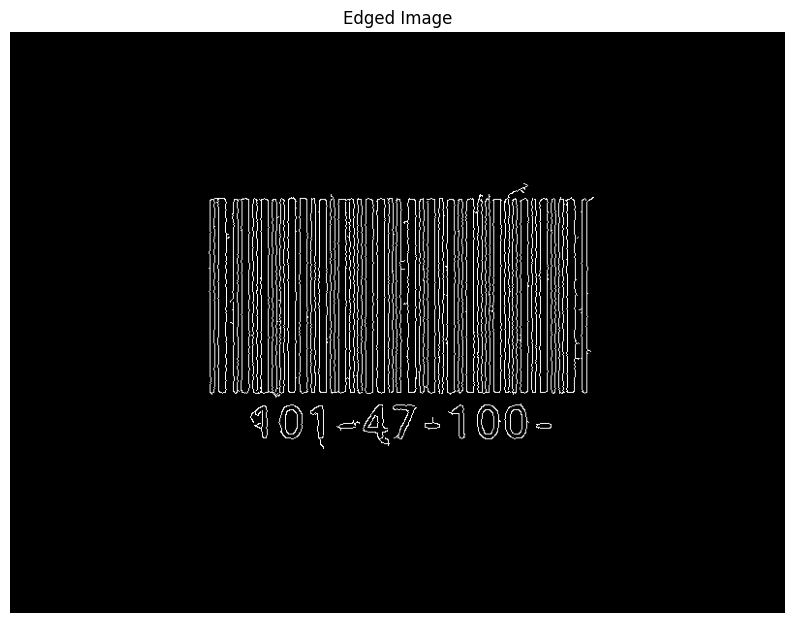

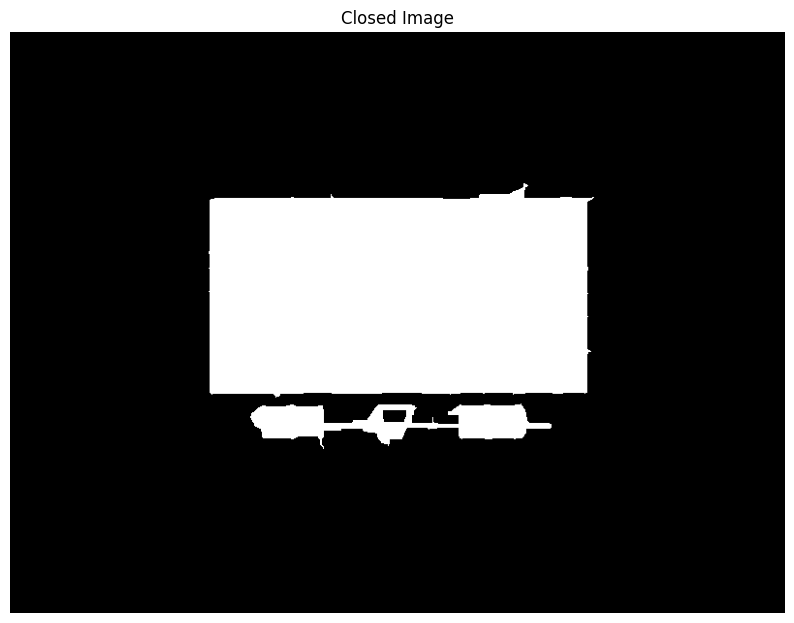

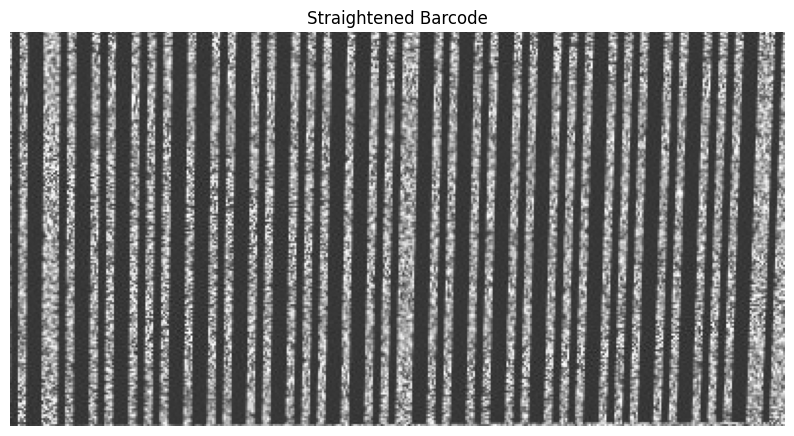

Straightened image saved to result.jpg


In [166]:
# Example usage
crop_barcode('Test Case Images/07 - mal7 w felfel.jpg', 'result.jpg')

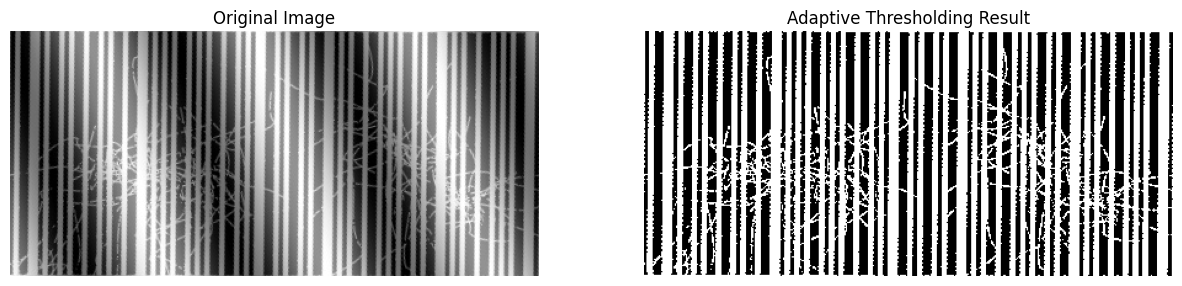

True

In [17]:
import cv2
import matplotlib.pyplot as plt

# Load the image in grayscale
image = cv2.imread('cropped_image.jpg', cv2.IMREAD_GRAYSCALE)

# Enhance the contrast (optional)


# Apply adaptive thresholding
adaptive_thresh = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 10
)

# Display the results
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1), plt.title("Original Image")
plt.imshow(image, cmap='gray'), plt.axis('off')
plt.subplot(1, 2, 2), plt.title("Adaptive Thresholding Result")
plt.imshow(adaptive_thresh, cmap='gray'), plt.axis('off')
plt.show()

#write the image
cv2.imwrite('thresholded_image.jpg', adaptive_thresh)

In [18]:
#for question 9

import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title, image):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def crop_barcode(image_path, output_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image from {image_path}")
        return

    # Add padding to the image to handle edge cases
    image = cv2.copyMakeBorder(image, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Apply edge detection
    edged = cv2.Canny(blurred, 50, 200, 255)

    # Apply morphological operations to close gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    barcode_contour = None

    # Use the largest contour even if it’s not a perfect rectangle
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)  # Ensure this is np.int32
        if cv2.contourArea(box) > 1000:  # Filter small areas
            barcode_contour = box
            break

    if barcode_contour is not None:
        # Get the rotated bounding box
        rect = cv2.minAreaRect(barcode_contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)  # Ensure this is np.int32

        # Calculate rotation matrix to correct orientation
        angle = rect[-1]
        if angle < -45:
            angle += 90
        rotation_matrix = cv2.getRotationMatrix2D(rect[0], angle, 1.0)

        # Rotate the entire image
        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

        # Crop the rotated bounding box
        width = int(rect[1][0])
        height = int(rect[1][1])
        cropped_image = cv2.getRectSubPix(rotated_image, (width, height), rect[0])

        # Ensure the cropped image is horizontal (rotate if needed)
        if cropped_image.shape[0] > cropped_image.shape[1]:
            cropped_image = cv2.rotate(cropped_image, cv2.ROTATE_90_CLOCKWISE)

        #add vertical replicate padding to the image using median filter upward

        # Show the final cropped image
        show_image("Cropped Barcode", cropped_image)

        # Save the cropped image
        cv2.imwrite(output_path, cropped_image)
        print(f"Straightened and cropped image saved to {output_path}")
    else:
        print("No barcode detected")

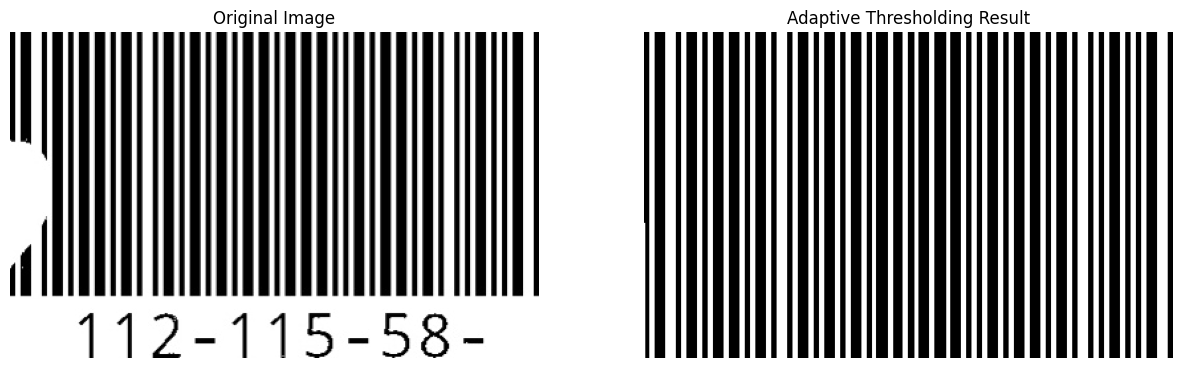

True

In [59]:
old_image = cv2.imread('straightened_image.jpg', cv2.IMREAD_GRAYSCALE)
processed_image = cv2.medianBlur(cv2.blur(old_image, (1, 9000)), 3)  # Apply a median filter first
_, processed_image = cv2.threshold(processed_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Apply Otsu's thresholding



plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1), plt.title("Original Image")
plt.imshow(old_image, cmap='gray'), plt.axis('off')
plt.subplot(1, 2, 2), plt.title("Adaptive Thresholding Result")
plt.imshow(processed_image, cmap='gray'), plt.axis('off')
plt.show()

#write the image
# add zero padding to the image

#remove white padding pixel at end of image


cv2.imwrite('result.jpg', processed_image)

Image loaded successfully.


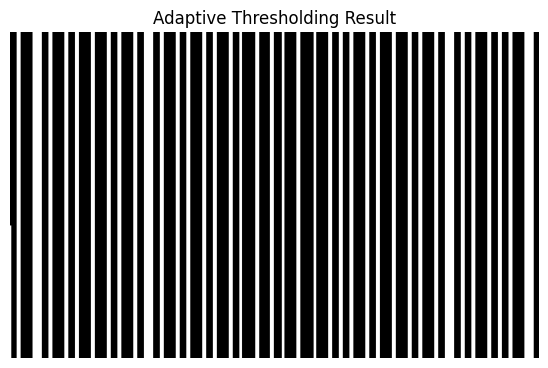

In [60]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('result.jpg', cv2.IMREAD_GRAYSCALE)

if image is None:
    print("Error: Image not found or unable to load.")
else:
    print("Image loaded successfully.")

# Apply thresholding to convert to binary (black and white)
_, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

# Create a kernel for morphological operations
kernel = np.ones((5, 2), np.uint8)  # vertical kernel for 1D barcode lines

# Apply dilation to make lines more uniform


# Apply erosion if the lines are too thick after dilation
eroded_image = cv2.erode(thresh, kernel, iterations=1)

# Save or process the result
cv2.imwrite('processed_barcode_image_result.jpg', eroded_image)

plt.figure(figsize=(15, 8))


plt.subplot(1, 2, 2), plt.title("Adaptive Thresholding Result")
plt.imshow(eroded_image, cmap='gray'), plt.axis('off')
plt.show()


In [62]:
my_image = cv2.imread('result.jpg', cv2.IMREAD_GRAYSCALE)
import numpy as np



# 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
    "00110": "Stop/Start",
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-",
}

# Get the average of each column in your image
mean = my_image.mean(axis=0)

# Set it to black or white based on its value
mean[mean <= 128] = 1
mean[mean > 128] = 0



# Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))


for pixel in pixels:
    if pixel == "0":
        pixels = pixels[1:-1]
    else:
        break

# Need to figure out how many pixels represent a narrow bar
# 7L MTNAK N8YRH B3DYH 3SHAN NNZL
narrow_bar_size = 0
for pixel in pixels:
    if pixel == "1":
        narrow_bar_size += 1
    else:
        break




wide_bar_size = narrow_bar_size * 2 - 1

digits = []
pixel_index = 0
current_digit_widths = ""
skip_next = False

while pixel_index < len(pixels):

    if skip_next:
        print(pixels[pixel_index])
        while(pixels[pixel_index] == '0'):
            pixel_index += 1
            if pixel_index >= len(pixels):
                break
        skip_next = False
        continue

    count = 1
    try:
        while pixels[pixel_index] == pixels[pixel_index + 1]:
            count += 1
            pixel_index += 1
    except:
        print("error")
        print(current_digit_widths)
        pass
    pixel_index += 1

    current_digit_widths += NARROW if count <= narrow_bar_size + 3 else WIDE

    if current_digit_widths in code11_widths:
        digits.append(code11_widths[current_digit_widths])
        current_digit_widths = ""
        skip_next = True  # Next iteration will be a separator, so skip it

print(digits)
print(narrow_bar_size)
print(wide_bar_size)

0
0
0
0
0
0
0
0
0
0
0
0
error
0011
['Stop/Start', '1', '1', '2', '-', '1', '0', '5', '-', '5', '8', '-', 'Stop/Start']
4
7


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def pad_image(image, padding_size):
    """
    Adds padding around the image to ensure the barcode doesn't touch the image borders.
    """
    padded_image = cv2.copyMakeBorder(image,
                                      padding_size, padding_size,
                                      padding_size, padding_size,
                                      cv2.BORDER_CONSTANT, value=(255, 255, 255))
    return padded_image

def restore_barcode_with_pattern(image, padding_size=100):
    """
    Restores the missing parts of the barcode by extrapolating the visible parts.
    """
    # Convert the image to grayscale for processing
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Threshold the image to create a binary version (black and white)
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # Find the edges of the barcode using the Canny edge detector
    edges = cv2.Canny(binary, threshold1=50, threshold2=150)

    # Create a mask for the missing parts (where edges are not present)
    missing_mask = cv2.bitwise_not(edges)

    # Use morphological transformations to close the gaps in the barcode
    kernel = np.ones((3, 3), np.uint8)
    closed_mask = cv2.morphologyEx(missing_mask, cv2.MORPH_CLOSE, kernel)

    # Inpainting to restore the missing parts based on the closed mask
    restored_image = cv2.inpaint(image, closed_mask, 3, cv2.INPAINT_TELEA)

    return restored_image

# Load the padded image (RGB format)
image_path = ''  # Provide the path to your padded image
padded_img = cv2.imread(image_path)
padded_img_rgb = cv2.cvtColor(padded_img, cv2.COLOR_BGR2RGB)

# Restore the barcode by extrapolating missing parts
restored_barcode = restore_barcode_with_pattern(padded_img_rgb)

# Display the restored barcode image
plt.figure(figsize=(8, 8))
plt.imshow(restored_barcode)
plt.axis('off')
plt.show()


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


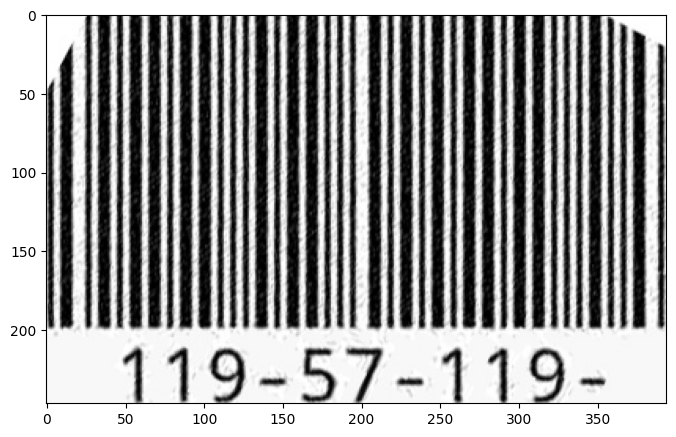

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_from_top_line_precisely(image, black_threshold=50, pixel_count_threshold=10):
    """
    Precisely crops the image starting from the first significant black line.

    :param image: Input image (grayscale or color).
    :param black_threshold: Intensity threshold to consider a pixel as black (default 50).
    :param pixel_count_threshold: Minimum number of black pixels in a row to consider it as a black line.
    :return: Cropped image starting from the first black line.
    """
    # Convert to grayscale if the image is not already
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Iterate through each row from top to bottom
    for y in range(gray_image.shape[0]):
        # Count the number of black pixels (close to 0 in grayscale)
        black_pixels = np.sum(gray_image[y] < black_threshold)  # Adjust threshold if needed
        if black_pixels > pixel_count_threshold:
            # Found the first black line, crop from this line down to the bottom
            return image[y:, :]

    # If no black line is detected, return the original image
    return image

# Load the image
image_path = 'cro2pped_image.jpg'  # Replace with the correct path to your image
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

if image is None:
    print("Error: Unable to load image. Please check the file path.")
else:
    # Crop the image from the first black line
    cropped_image = crop_from_top_line_precisely(image, black_threshold=50, pixel_count_threshold=10)

    # Display the cropped image
    plt.figure(figsize=(8, 8))
 # Grayscale image
    plt.imshow(cropped_image, cmap='gray')
